# Biogeoscience case study

The two case studies in this folder from climate science and biogeosciences follow the QAD-questionnaire and method-selection flow chart in the following Review paper (included in the tigramite github tutorial folder):

Runge, J., Gerhardus, A., Varando, G., Eyring, V. & Camps-Valls, G. Causal inference for time series. Nat. Rev. Earth Environ. 10, 2553 (2023).

A list of methods with software to address selected QAD problems appears at the end of that Review paper.

This example will demonstrate the use of causal inference based techniques to investigate the causal effect of air temperature (Tair) on ecosystem respiration (Reco) from data that also includes gross primary production (GPP) and shortwave radiation (Rg). To better illustrate non-parametric causal effect estimation, this case study considers a synthetic system with known quantitative ground truth:

\begin{align}\label{eq:biogeoscience_model}
\begin{split}
\text{Rg}_t &= \lvert 280~\sin(t \pi /365)^2 + 50~\lvert\sin(t \pi /365)\rvert\eta^{\text{Rg}}_t\rvert \\
\text{Tair}_t &= 0.8~\text{Tair}_{t-1} + 0.02~\text{Rg}_t + 5 \eta^{\text{Tair}}_t \\
\text{GPP}_t &= \lvert 0.2~\text{GPP}_{t-1} + 0.002~\text{Tair}_t~\text{Rg}_t + 3 \eta^{\text{GPP}}_t \rvert \\ 
\text{Reco}_t &= \lvert 0.3~\text{Reco}_{t-1} + 0.9~\text{GPP}_t~0.8^{0.12(\text{Tair}_t-15)} + 2 \eta^{\text{Reco}}_t \rvert
\end{split}
\end{align}

In these equations, which are interpreted as an SCM, the $\eta^{\cdot}_t$ are mutually independent standard normal noise terms, except for Tair where $\eta^{\text{Tair}}_t=\eta_t+\frac{1}{4}\epsilon_t^3$ (standard normal noises $\eta$ and $\epsilon$) with a cubic exponent to represent more extreme temperatures. The SCM exhibits a unimodal relationship between Reco and Tair (see the interventional ground truth in the figures below), which has also been found in real data (see paper).

The analysis will first illustrate causal discovery and then causal effect estimation. Let's start with some imports of standard python packages as well as the tigramite causal inference package.

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

import sys
from copy import deepcopy

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import tigramite
import tigramite.data_processing as pp
import tigramite.plotting as tp

from tigramite.models import LinearMediation, Models
from tigramite.causal_effects import CausalEffects

from tigramite.pcmci import PCMCI
from tigramite.independence_tests.robust_parcorr import RobustParCorr

## Data generation and plotting

The steps again closely follow the QAD-template (Tab. 1 and Fig. 2 flow chart in Review paper). As opposed to the climate example, here all variables (nodes) are already defined as daily continuously-valued time series. The next question is about creating a stationary dataset (Fig. 2 flow chart). Unlike in the climate example, here a setting with multiple datasets (multiple sites) is considered. In the considered synthetic example, stationarity is fulfilled by construction (apart from seasonality shared by all sites), as the sites are just different realizations of the same SCM. Hence, the time series from the different sites can be simply aggregated (pooled). To alleviate the seasonal non-stationarity, only the period April-September (model months) is considered (see figure below).

In [40]:
# Time series length is 6 years
T = 365*6 + 1

# 4 Variables
N = 4

# We model 5 measurement sites
M = 5

data_dict = {}
mask_dict = {}
for site in range(M):

    modeldata_mask = np.ones((T, N), dtype='int')
    for t in range(T):
        # April to September
        if 90 <= t % 365 <= 273:
            modeldata_mask[t,:] = 0
            
    mask_dict[site] = modeldata_mask

    modeldata = np.zeros((T,N))
    random_state = np.random.RandomState(site)
    noise = random_state.randn(T, N)
    noise[:, 1] += 0.25*random_state.randn(T)**3
        
    for t in range(5, T):
        modeldata[t,0] = np.abs(280.*np.abs(np.sin((t)*np.pi/365.))**2 + 50.*np.abs(np.sin(t*np.pi/365.))*noise[t,0])
        modeldata[t,1] = 0.8*modeldata[t-1,1] + 0.02*modeldata[t,0] + 5*noise[t,1]  
        modeldata[t,2] = np.abs(0.2* modeldata[t-1, 2] + 0.002*modeldata[t,0] * modeldata[t,1] + 3*noise[t,2]) 
        modeldata[t,3] = np.abs(0.3*modeldata[t-1,3] + 0.9*modeldata[t,2] * 0.8**(0.12*(modeldata[t,1]-15)) + 2*noise[t,3])
    data_dict[site] = modeldata

# Variable names
var_names = ['Rg', 'Tair', 'GPP', 'Reco']

# Init Tigramite dataframe object
dataframe = pp.DataFrame(data=data_dict, 
                    mask = mask_dict,
                    analysis_mode = 'multiple',
                    var_names=var_names)

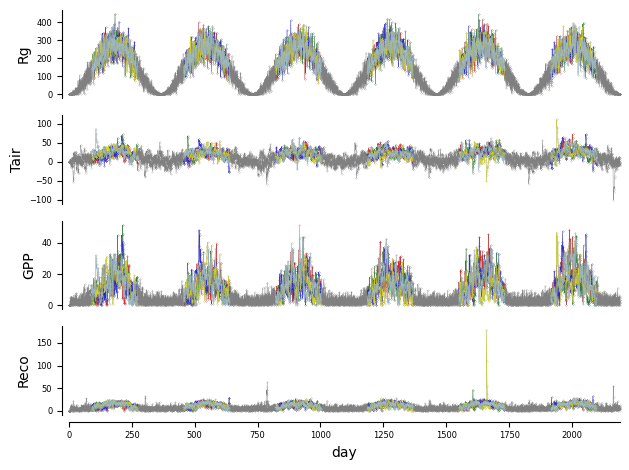

In [41]:
fig_axes = tp.plot_timeseries(dataframe,
                   grey_masked_samples='data',
                   adjust_plot=False,
                   color = 'red',
                   alpha=0.6, 
                   data_linewidth=0.3,
                   selected_dataset=0)

for index in range(1, len(data_dict)):
    adjust_plot = False
    if index == M - 1: 
        adjust_plot = True
    color = ['red', 'green', 'blue', 'yellow', 'lightblue'][index]
    tp.plot_timeseries(dataframe,
                       fig_axes =fig_axes,
                       grey_masked_samples='data',
                       adjust_plot=adjust_plot,
                       color=color,
                       time_label='day',
                       alpha=0.6, 
                       data_linewidth=0.3,
                       selected_dataset=index)
plt.show()

The grey samples are masked out. Note the extreme values occuring due to nonlinearities.

## Causal discovery analysis

Given this stationary dataset, the first causal question is about causal discovery. To choose the appropriate causal discovery method, assumptions that can reasonably be made must be determined. The data here comes from multiple datasets (blue box in the causal discovery frame, Fig. 2 in paper), however, the datasets share the same underlying distribution and the next question is whether this system is deterministic. Given the complexity of the dynamics at this scale, it can be assumed to be a non-deterministic system. The next assumption to be made is whether or not there might be hidden confounders, that is, unobserved variables that causally influence two or more observed variables. Here, due to restricting the analysis to seasons across which stationarity can be expected, it is reasonable to assume the absence of hidden confounding, which is true in the underlying SCM. 

The structural assumption of the graph type then needs to be made. As the processes here are fast, contemporaneous causal effects (that is, causal influences on a time scale below the data's time resolution of 1 day) might occur. Further, here the domain knowledge that Rg is exogeneous can be enforced by not allowing any parents of Rg in the graph. These assumptions suggest using the constraint-based causal discovery algorithm PCMCI$^+$ (or other similar options, Fig. 2). 

To make an assumption on the maximal time lag in the causal time series graph estimated by PCMCI$^+$ (that is, the maximum over all $\tau$ such that $X^i_{t-\tau}\tailhead X^j_t$ is in the graph), data can be used to investigate the lagged dependency functions, or, as done here, domain knowledge can be used to justify $\tau_{\max}=1$ (in units of days). 

The next hyperparameter choice for PCMCI$^+$ is about the conditional independence test, which requires a parametric assumption. Below we use Tigramite's ``plot_densities`` function to investigate distributional properties. Here we depict the raw data as well as transformed data that achieves normally-distributed marginals.




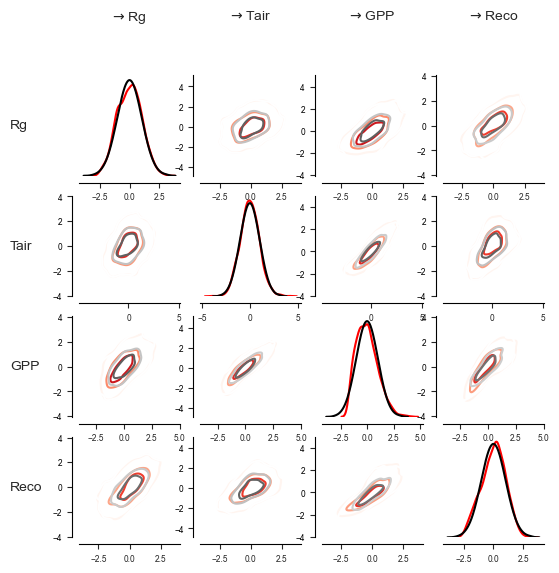

In [44]:
dataframe_here = deepcopy(dataframe)
matrix_lags = None
matrix = tp.setup_density_matrix(N=N, 
        var_names=dataframe.var_names, **{
        'figsize':(6, 6), 
        'tick_label_size':6,
        'label_space_left':0.18})

# Standardize data to make it comparable
data_dict_here = deepcopy(data_dict)
for m in data_dict_here.keys():
    mean, std = pp.weighted_avg_and_std(data_dict_here[m], axis=0, weights=(mask_dict[m]==False))

    data_dict_here[m] -= mean
    data_dict_here[m] /= std

dataframe_here = pp.DataFrame(data_dict_here,
        analysis_mode='multiple',
     mask=mask_dict, var_names=var_names,)

matrix.add_densityplot(dataframe=dataframe_here, 
    matrix_lags=matrix_lags, label_color='red', 
    snskdeplot_args = {'cmap':'Reds', 'alpha':1., 'levels':4})

# Now transform data to normal marginals
data_normal = deepcopy(data_dict)
for m in data_normal.keys():
    data_normal[m] = pp.trafo2normal(data_dict[m], mask=mask_dict[m])
dataframe_normal = pp.DataFrame(data_normal,
    analysis_mode='multiple',
 mask=mask_dict, var_names=var_names)

matrix.add_densityplot(dataframe=dataframe_normal, 
    matrix_lags=matrix_lags, label_color='black', 
    snskdeplot_args = {'cmap':'Greys', 'alpha':1., 'levels':4})

# matrix.adjustfig(name="data_density.pdf', show_labels=False)

The marginal densities (red) are slightly non-normal, but by transforming the variables such that their marginals are normally distributed, the resulting joint densities are reasonably linear. Therefore, conditional independence tests in PCMCI$^+$ should be undertaken with a robust partial correlation (RobustParCorr), which is a variant of partial correlation where the variables are first transformed to normally-distributed marginals.

The data from all sites and all of the six years can now be used to estimate a single causal graph. Alternatively, a sliding window analysis should be considered if non-stationarity of the causal graph could be present. More for illustrative purposes, a sliding window analysis is applied here that learns five causal graphs, each by combing data from two successive of the six years and across all sites (hence $5 = 6-1$ graphs, each estimated from $n=1840$ samples due to masking).

In [64]:
# Maximum time lag
tau_max = 1

# Conditional independence test
cond_ind_test = RobustParCorr(mask_type='y', verbosity=0)

# Significance level
pc_alpha = 0.05

# Stepsize of sliding windo
window_step = 365*1

# Length of sliding window
window_length = 365*2

# First set link assumptions to remove parents of Rg
# link_assumptions = None
link_assumptions = {}
for j, var in enumerate(var_names):
    if var == 'Rg':
        link_assumptions[j] = {(j, -tau):'o?' for tau in range(0, tau_max+1)}
    else:
        link_assumptions[j] = [(i, -tau) for i in range(N) for tau in range(0, tau_max+1)]

link_assumptions_absent_link_means_no_knowledge = {0: {(i, -tau):'' for i in range(N) for tau in range(0, tau_max+1) if not (i==0 and tau==0)}}
link_assumptions =  PCMCI.build_link_assumptions(link_assumptions_absent_link_means_no_knowledge=link_assumptions_absent_link_means_no_knowledge,
                                   n_component_time_series=N,
                                   tau_max=tau_max,
                                   tau_min=0)
print(link_assumptions)

{0: {}, 1: {(0, 0): 'o?o', (0, -1): 'o?>', (1, -1): 'o?>', (2, 0): 'o?o', (2, -1): 'o?>', (3, 0): 'o?o', (3, -1): 'o?>'}, 2: {(0, 0): 'o?o', (0, -1): 'o?>', (1, 0): 'o?o', (1, -1): 'o?>', (2, -1): 'o?>', (3, 0): 'o?o', (3, -1): 'o?>'}, 3: {(0, 0): 'o?o', (0, -1): 'o?>', (1, 0): 'o?o', (1, -1): 'o?>', (2, 0): 'o?o', (2, -1): 'o?>', (3, -1): 'o?>'}}


In [65]:
# Initialize PCMCI class
pcmci = PCMCI(
        dataframe=dataframe, 
        cond_ind_test=cond_ind_test,
        verbosity=0)

method_args={'tau_min':0, 'tau_max':tau_max, 
            'pc_alpha':pc_alpha,
            'link_assumptions':link_assumptions,
            }

# Run
summary_results = pcmci.run_sliding_window_of(method='run_pcmciplus', 
                                            method_args=method_args, 
                                            window_step=window_step,
                                            window_length=window_length,
                                            conf_lev = 0.9)

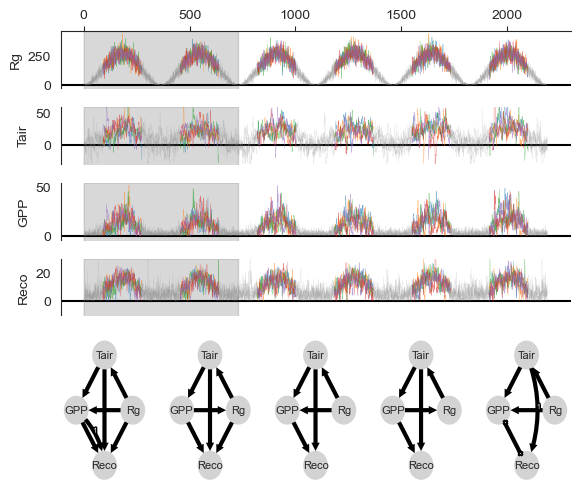

In [66]:

graphs = summary_results['window_results']['graph']
val_matrices = summary_results['window_results']['val_matrix']
n_windows = len(graphs)

mosaic = [['data %s' %j for i in range(n_windows)] for j in range(N)]
mosaic.append(['graph %s' %i for i in range(n_windows)])

fig, axs = plt.subplot_mosaic(mosaic = mosaic, 
                                figsize=(6, 5.),  #(6.5, 4.)
                              gridspec_kw={'height_ratios' : [0.6/N for i in range(N)] + [0.4]
                               } ,)

reference = np.where(np.fromiter(dataframe.time_offsets.values(), dtype=int) == 0)[0][0]

for j in range(N):
    ax = axs['data %s' %j]
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.axhline(0., color='black')

    ref_datatime = dataframe.datatime[reference]
    len_ref = len(ref_datatime)

    w = 0
    ax.fill_between(x=ref_datatime, y1=-1, y2=1, 
            where=(np.arange(len_ref) >= w*window_step)*(np.arange(len_ref) < w*window_step+window_length), color='grey', 
                    alpha=0.3, zorder=-5,
            transform=trans)

    color = 'black'
    for idata in range(dataframe.M):
        data = deepcopy(dataframe.values[idata])
        mask = dataframe.mask[idata].copy()
        datatime = dataframe.datatime[idata].copy()
        # print(data.shape, datatime.shape, T,)

        masked_data = deepcopy(data) #.copy()
        data[mask==1] = np.nan
        masked_data[mask==0] = np.nan
        if j == 0: label = "Site %d" %(idata + 1)
        else: label = None
        ax.plot(datatime, data[:,j], label = label, lw=0.3, alpha=0.6, clip_on=True) #, color=color)
        ax.plot(datatime, masked_data[:,j], color='grey', lw=0.3, alpha=0.2, clip_on=True) #, color=color)

    if j == 0: 
        for loc, spine in ax.spines.items():
            if loc not in ['left', 'top']:
                spine.set_color("none")
        ax.xaxis.tick_top()
    else:
        ax.xaxis.set_ticks([]) 
        for loc, spine in ax.spines.items():
            if loc not in ['left']:
                spine.set_color("none")  


    ax.set_ylabel(var_names[j])

    if j == 1: ax.set_ylim(-30, 60)
    if j == 3: ax.set_ylim(None, 30)


for w in range(n_windows):
    if w == 0: show_colorbar=False
    else: show_colorbar = False
    tp.plot_graph(graphs[w], 
        # val_matrix=val_matrices[w], 
        var_names=var_names,
        show_colorbar=False,  #show_colorbar
        node_label_size=8,
        node_size=0.5,
        arrow_linewidth=3.0,
        link_label_fontsize=5,
        fig_ax=(fig, axs['graph %s' %w]))

fig.subplots_adjust(left=0.12, right=0.97, bottom=0.02, top = 0.93, wspace=0.2, hspace=0.25)